In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import scipy.stats as st
import math
import datetime
import missingno as msno
from scipy.stats import norm, skew
from sklearn import metrics
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor

from termcolor import colored
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#to see model hyperparameters
from sklearn import set_config
set_config(print_changed_only = False)

# to show all columns
pd.set_option('display.max_columns', 15)


ADQUISICION DE DATOS

In [31]:
car = pd.read_csv("Car details v3.csv")
df = car.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


LIMPIEZA DE DATOS

In [32]:
categoric_columns = ["fuel", "transmission", "owner", "seller_type"]
for column in categoric_columns:
    df[column] = df[column].astype("category")

In [33]:
df["car_brand_name"] = df["name"].str.extract('([^\s]+)')
df["car_brand_name"] = df["car_brand_name"].astype("category")
df["engine"] = df["engine"].str.extract('([^\s]+)').astype("float")
df["mileage"] = df["mileage"].str.extract('([^\s]+)').astype("float")
df["max_power"] = df["max_power"].str.extract('([^\s]+)')
df["max_power"] = df["max_power"][~(df["max_power"] == "bhp")]
df["max_power"] = df["max_power"].astype("float")
df["car_age"] = (datetime.datetime.now().year) - (df["year"])
df.drop(["name", "year", "torque"], axis = 1, inplace = True)


In [34]:
df.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,Maruti,10
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,Skoda,10
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,Honda,18
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,Hyundai,14
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,Maruti,17


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   selling_price   8128 non-null   int64   
 1   km_driven       8128 non-null   int64   
 2   fuel            8128 non-null   category
 3   seller_type     8128 non-null   category
 4   transmission    8128 non-null   category
 5   owner           8128 non-null   category
 6   mileage         7907 non-null   float64 
 7   engine          7907 non-null   float64 
 8   max_power       7912 non-null   float64 
 9   seats           7907 non-null   float64 
 10  car_brand_name  8128 non-null   category
 11  car_age         8128 non-null   int64   
dtypes: category(5), float64(4), int64(3)
memory usage: 486.3 KB


In [36]:
df.isnull().sum()

selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage           221
engine            221
max_power         216
seats             221
car_brand_name      0
car_age             0
dtype: int64

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
selling_price,8128.0,638271.807702,806253.403508,29999.0,254999.00,450000.0,675000.00,10000000.0
km_driven,8128.0,69819.510827,56550.554958,1.0,35000.00,60000.0,98000.00,2360457.0
mileage,7907.0,19.418783,4.037145,0.0,16.78,19.3,22.32,42.0
engine,7907.0,1458.625016,503.916303,624.0,1197.00,1248.0,1582.00,3604.0
max_power,7912.0,91.517919,35.822499,0.0,68.05,82.0,102.00,400.0
seats,7907.0,5.416719,0.959588,2.0,5.00,5.0,5.00,14.0
car_age,8128.0,10.195989,4.044249,4.0,7.00,9.0,13.00,41.0


In [38]:
df.describe(include = "category").T

,count,unique,top,freq
fuel,8128,4,Diesel,4402
seller_type,8128,3,Individual,6766
transmission,8128,2,Manual,7078
owner,8128,5,First Owner,5289
car_brand_name,8128,32,Maruti,2448


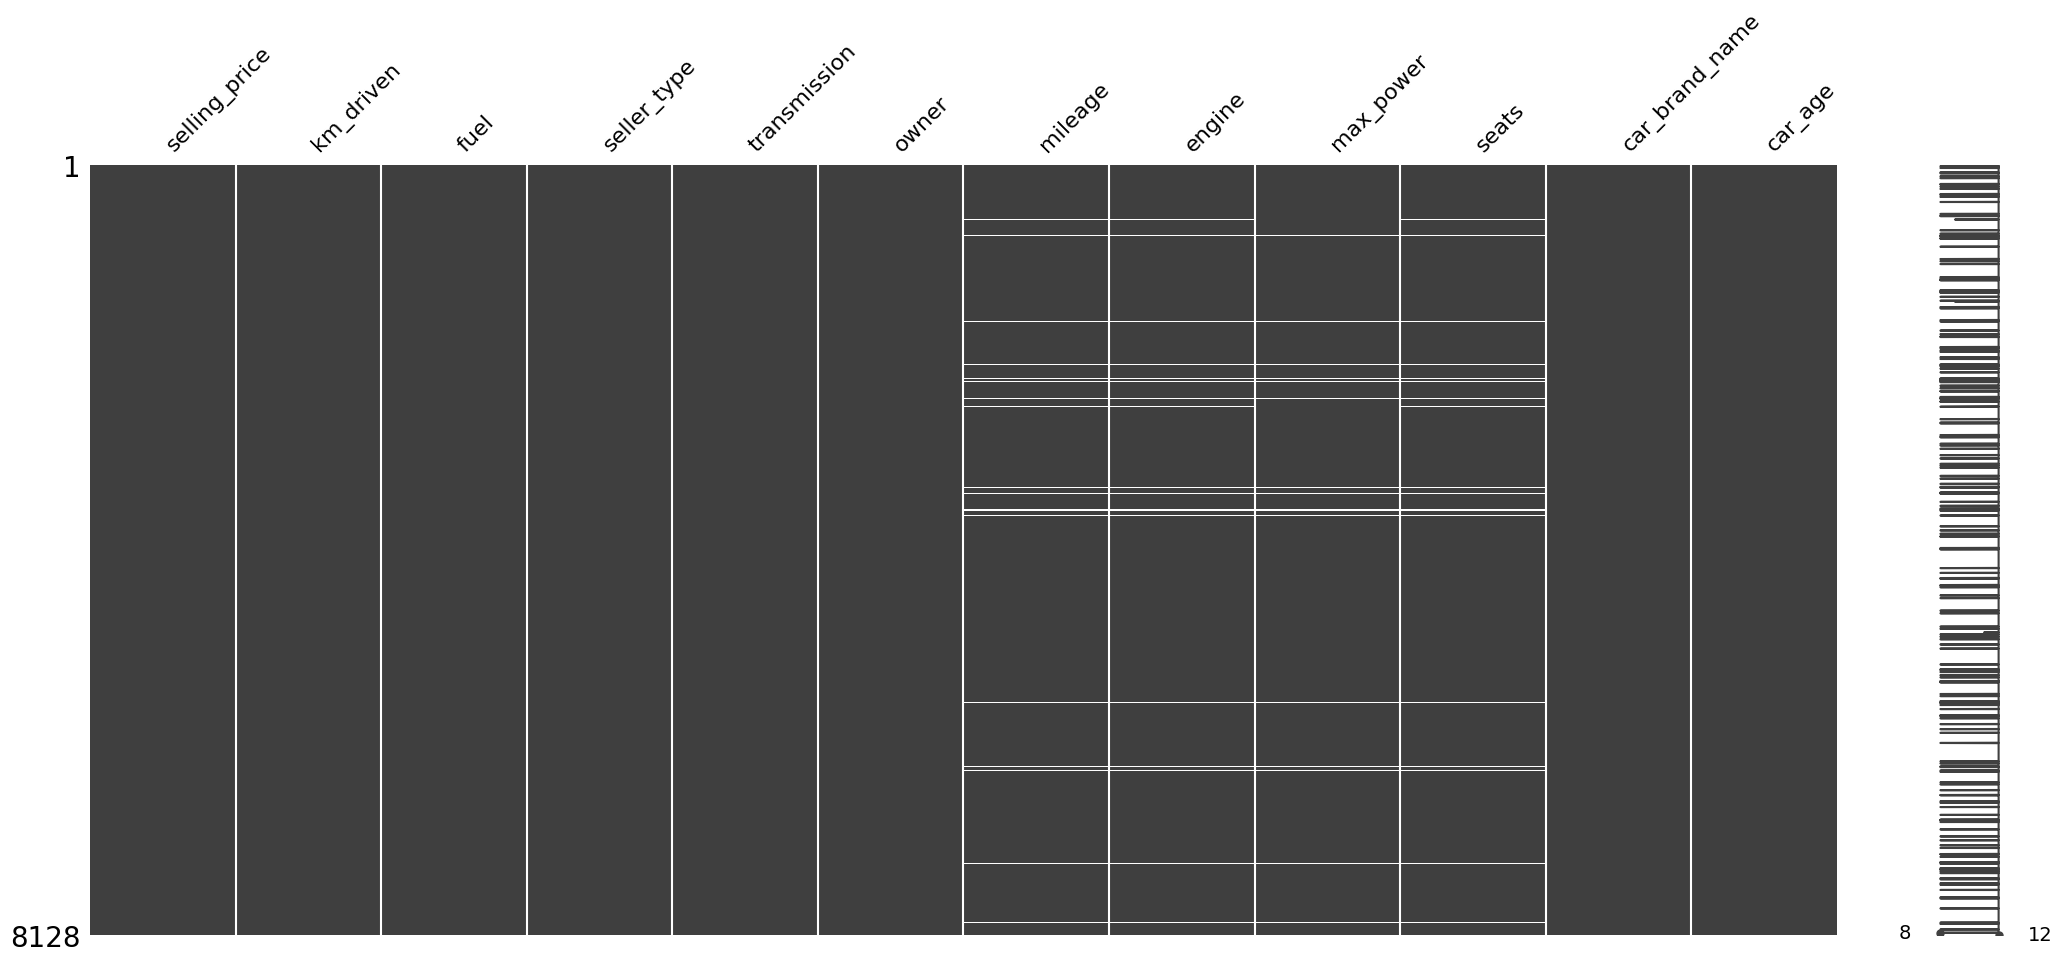

In [39]:
msno.matrix(df);

<Figure size 1000x500 with 0 Axes>

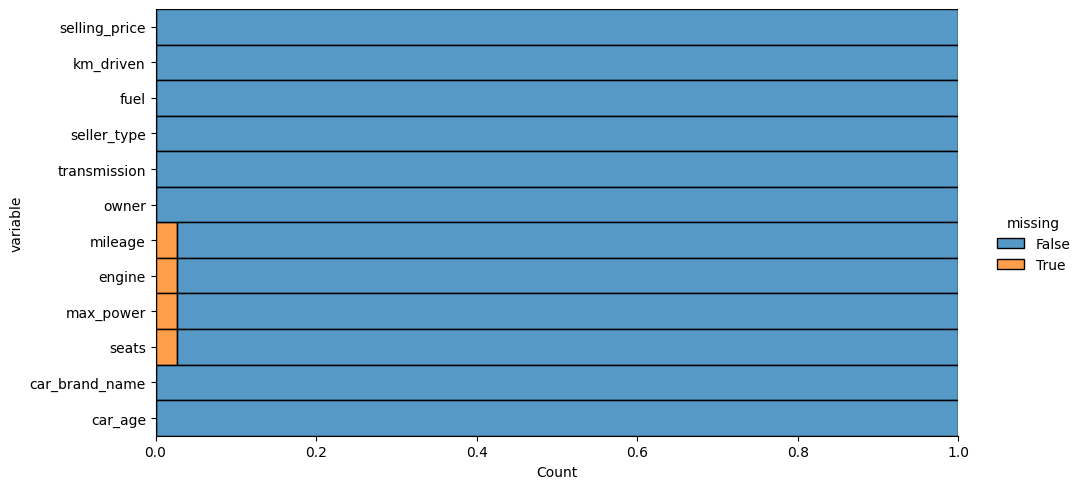

In [40]:
plt.figure(figsize = (10, 5))
sns.displot(
    data = df.isna().melt(value_name = "missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 2
);
plt.show()

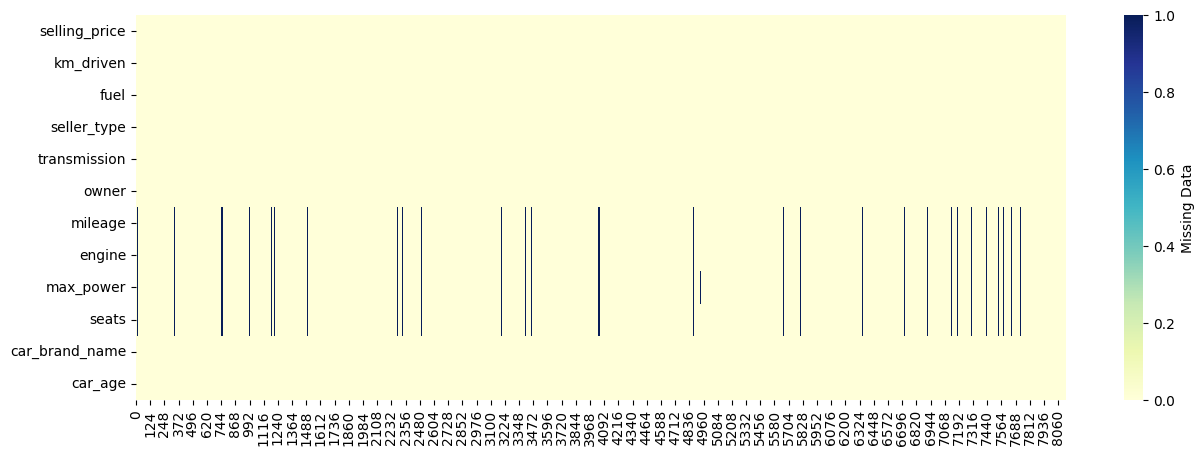

In [41]:
plt.figure(figsize = (15, 5))
sns.heatmap(df.isna().transpose(),
            cmap = "YlGnBu",
            cbar_kws = {'label': 'Missing Data'});
plt.show()

In [42]:
numeric_data = [column for column in df.select_dtypes(["int", "float"])]
categoric_data = [column for column in df.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    df[col].fillna(df[col].median(), inplace = True)
        
#replace missing values in each categorical column with the most frequent value
for col in categoric_data:
    df[col].fillna(df[col].value_counts().index[0], inplace = True)

In [43]:
df.isnull().sum().sum()

0

In [44]:
print("Frecuencia de clase de la variable 'transmission': \n\n", df["transmission"].value_counts())

print("_____________________________________________________________________________________")

print("Frecuencia de clase de la variable 'seller_type': \n\n", df["seller_type"].value_counts())

print("_____________________________________________________________________________________")

print("Frecuencia de clase de la variable 'owner': \n\n", df["owner"].value_counts())

print("_____________________________________________________________________________________")

print("Frecuencia de clase de la variable 'car_brand_name': \n\n", df["car_brand_name"].value_counts())

Frecuencia de clase de la variable 'transmission': 

 transmission
Manual       7078
Automatic    1050
Name: count, dtype: int64
_____________________________________________________________________________________
Frecuencia de clase de la variable 'seller_type': 

 seller_type
Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: count, dtype: int64
_____________________________________________________________________________________
Frecuencia de clase de la variable 'owner': 

 owner
First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: count, dtype: int64
_____________________________________________________________________________________
Frecuencia de clase de la variable 'car_brand_name': 

 car_brand_name
Maruti           2448
Hyundai          1415
Mahindra          772
Tata              734
Toyota            488
Honda             467
Ford              39

In [45]:
df.to_csv("car_data_cleaned.csv", index=False)

VISUALIZACION DE DATOS

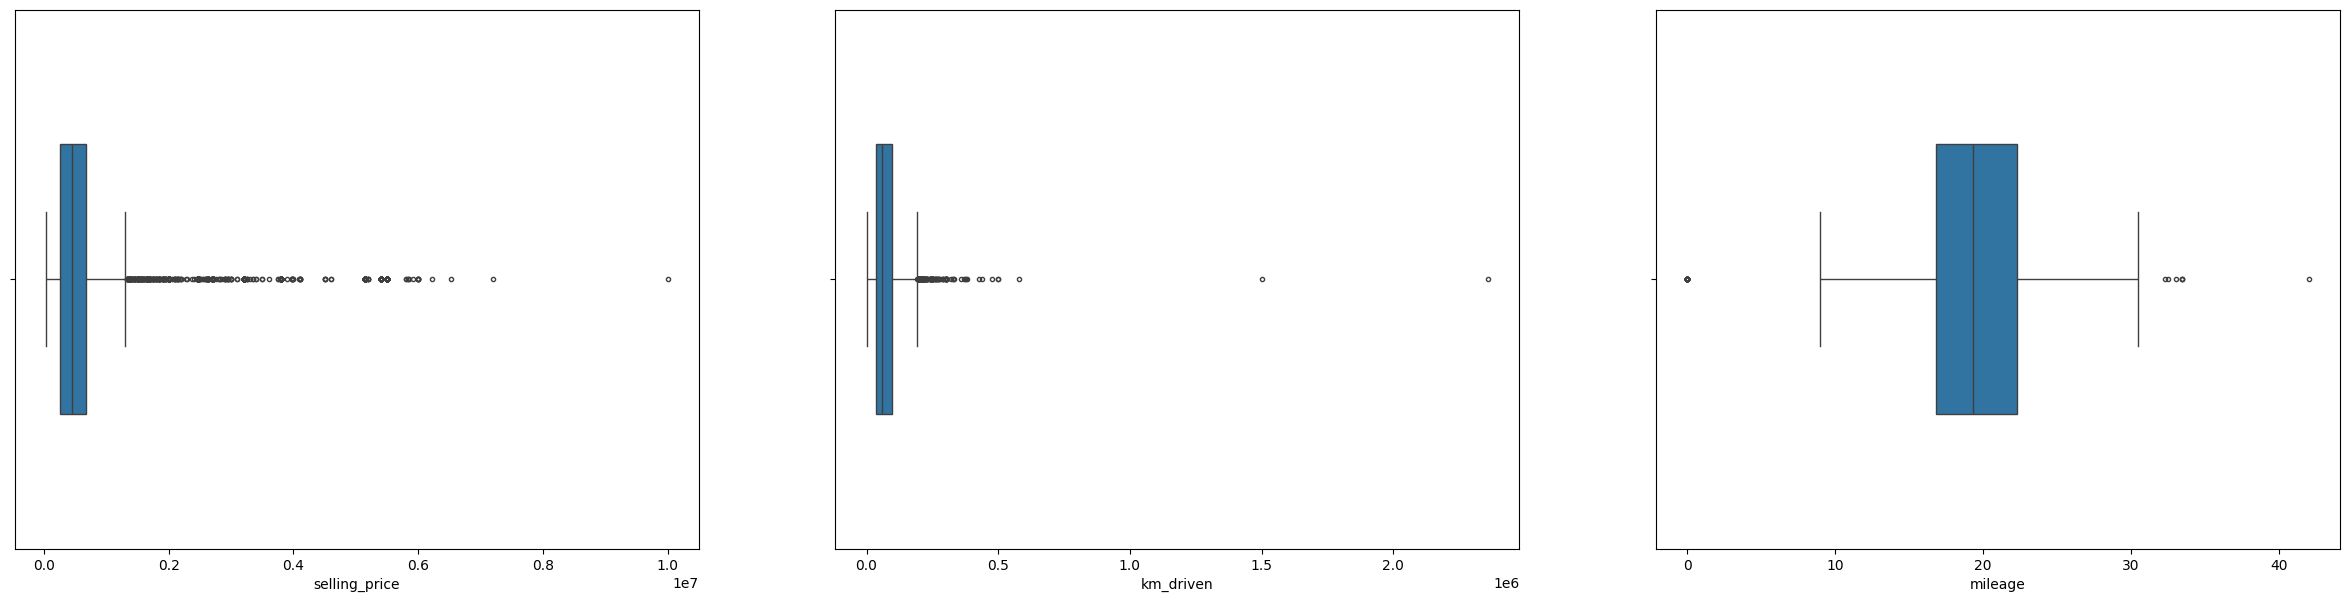

In [46]:
fig, axes = plt.subplots(1, 3, figsize = (30, 7))

sns.boxplot(ax = axes[0], x = "selling_price", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "km_driven", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "mileage", data = df, width = 0.5, fliersize = 3, linewidth = 1);

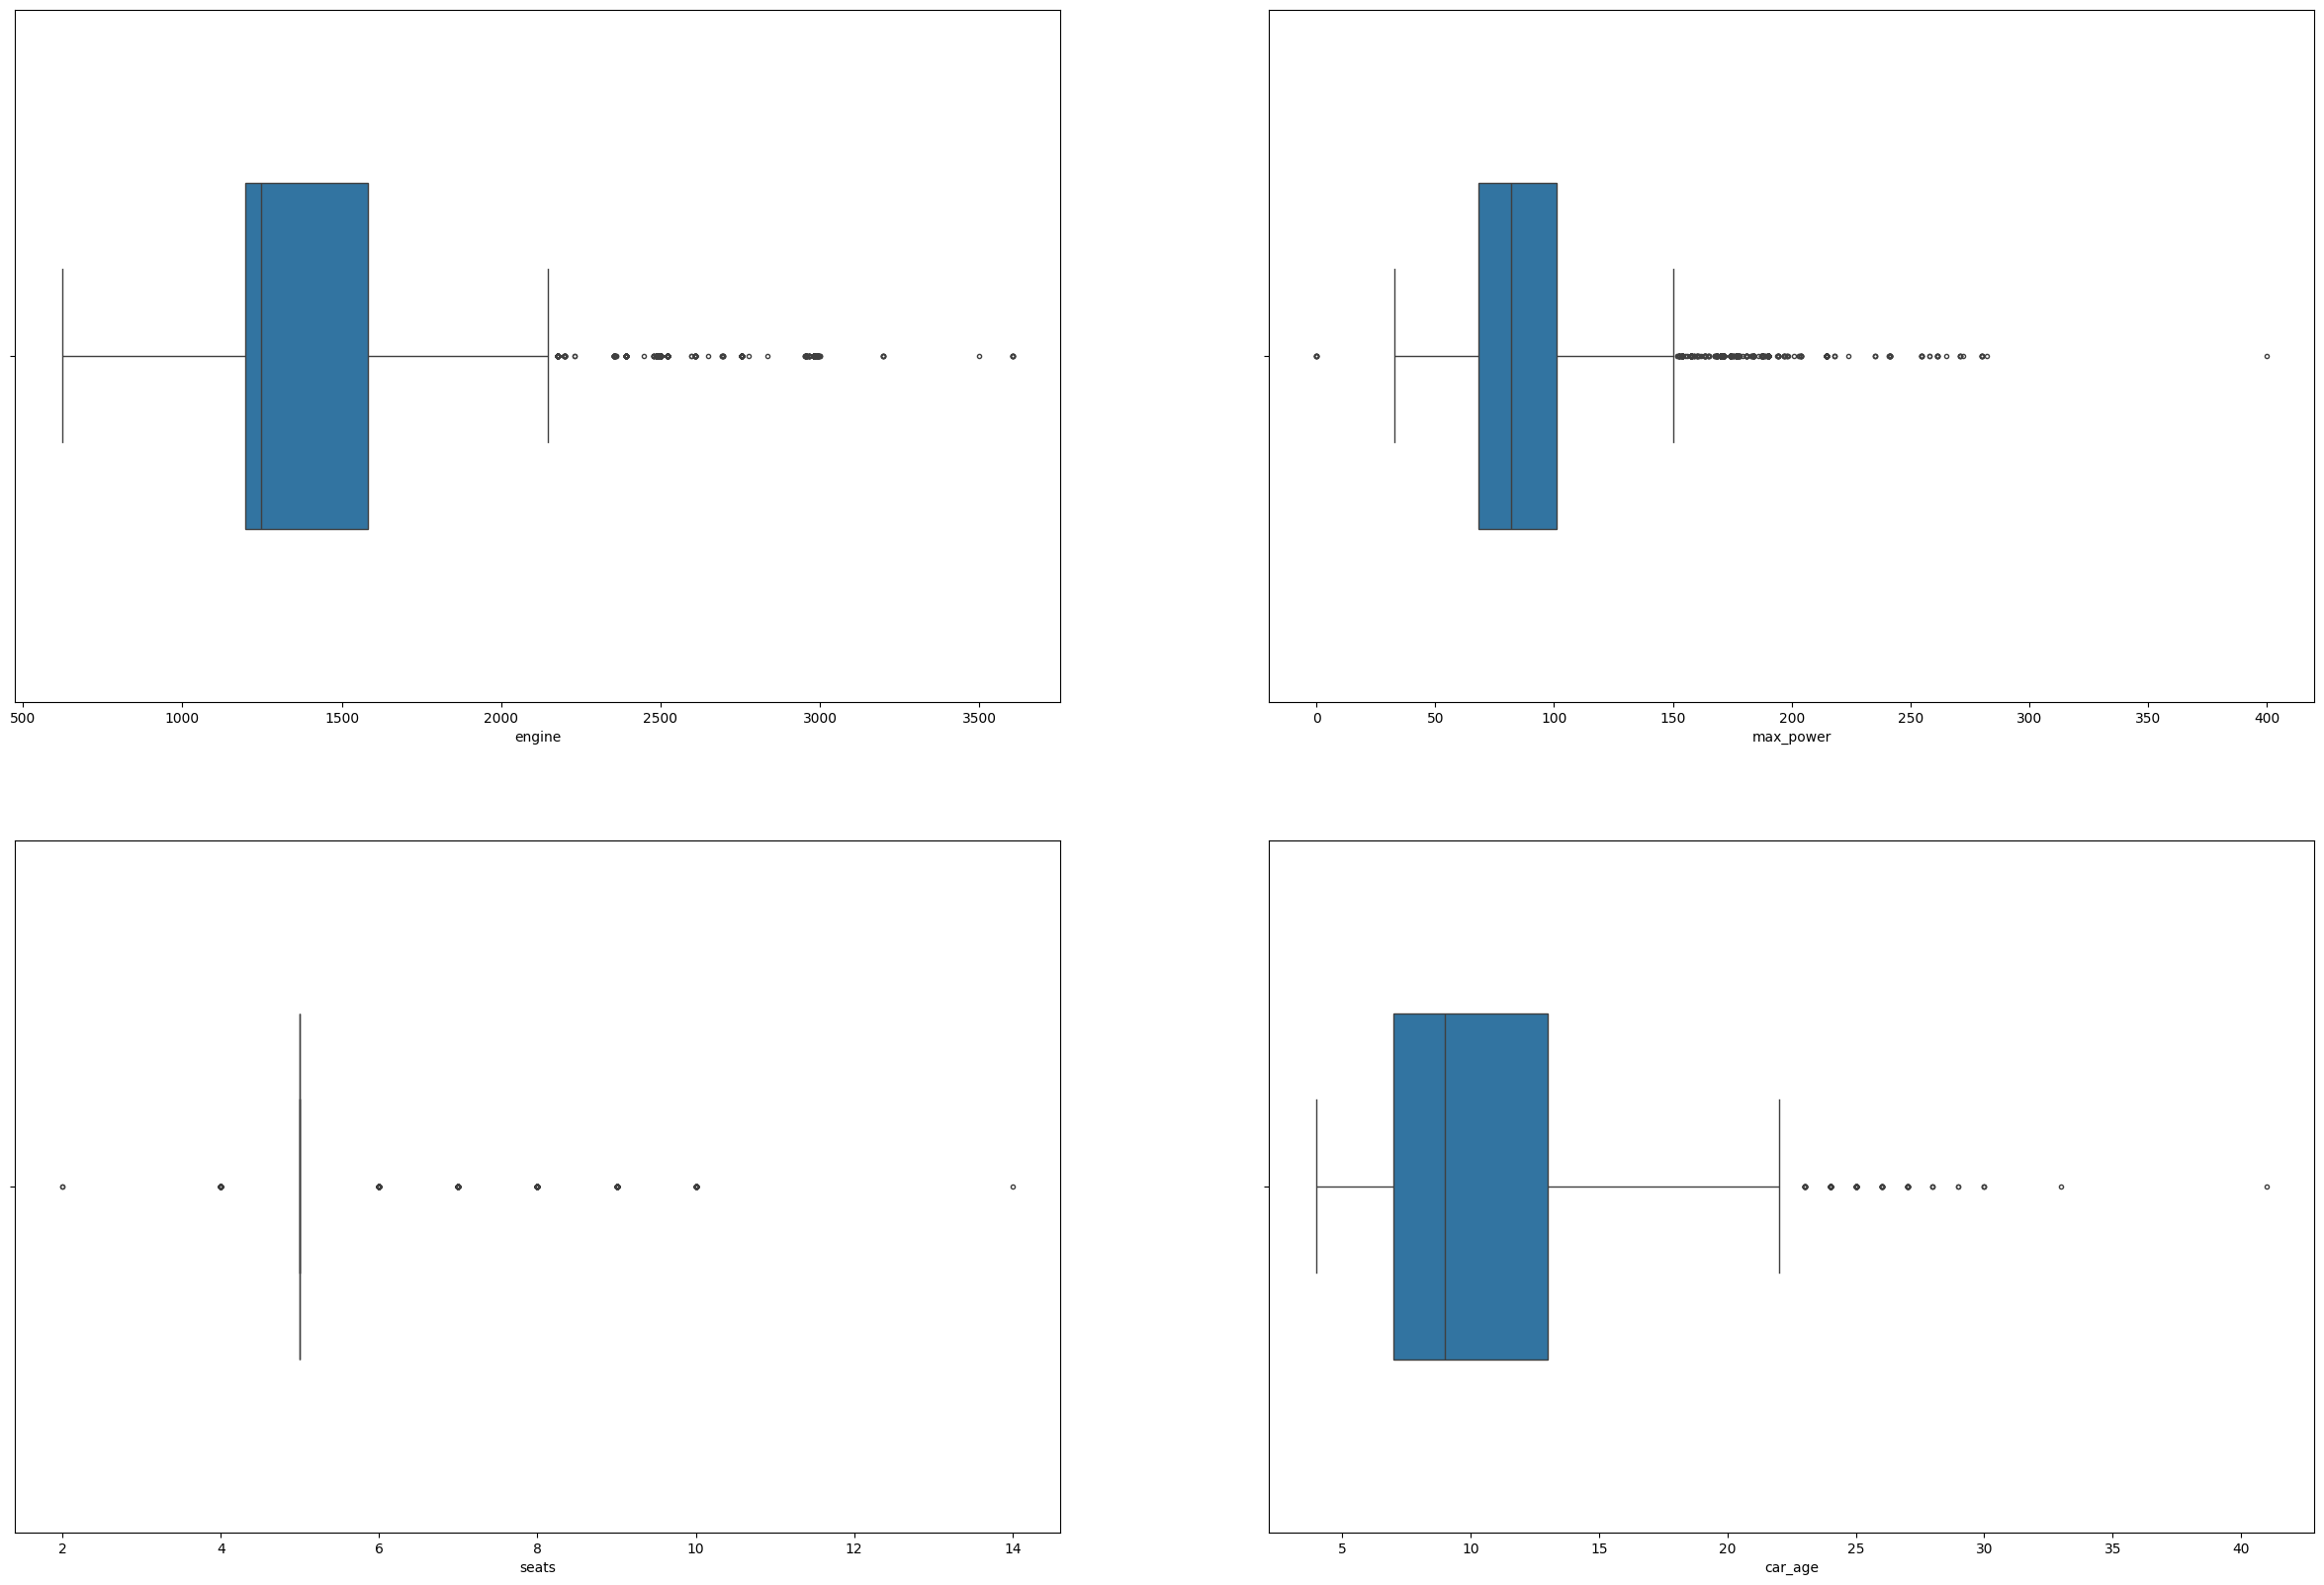

In [47]:
fig, axes = plt.subplots(2, 2, figsize = (30, 20))
axes = axes.flatten()

sns.boxplot(ax = axes[0], x = "engine", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "max_power", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "seats", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[3], x = "car_age", data = df, width = 0.5, fliersize = 3, linewidth = 1);

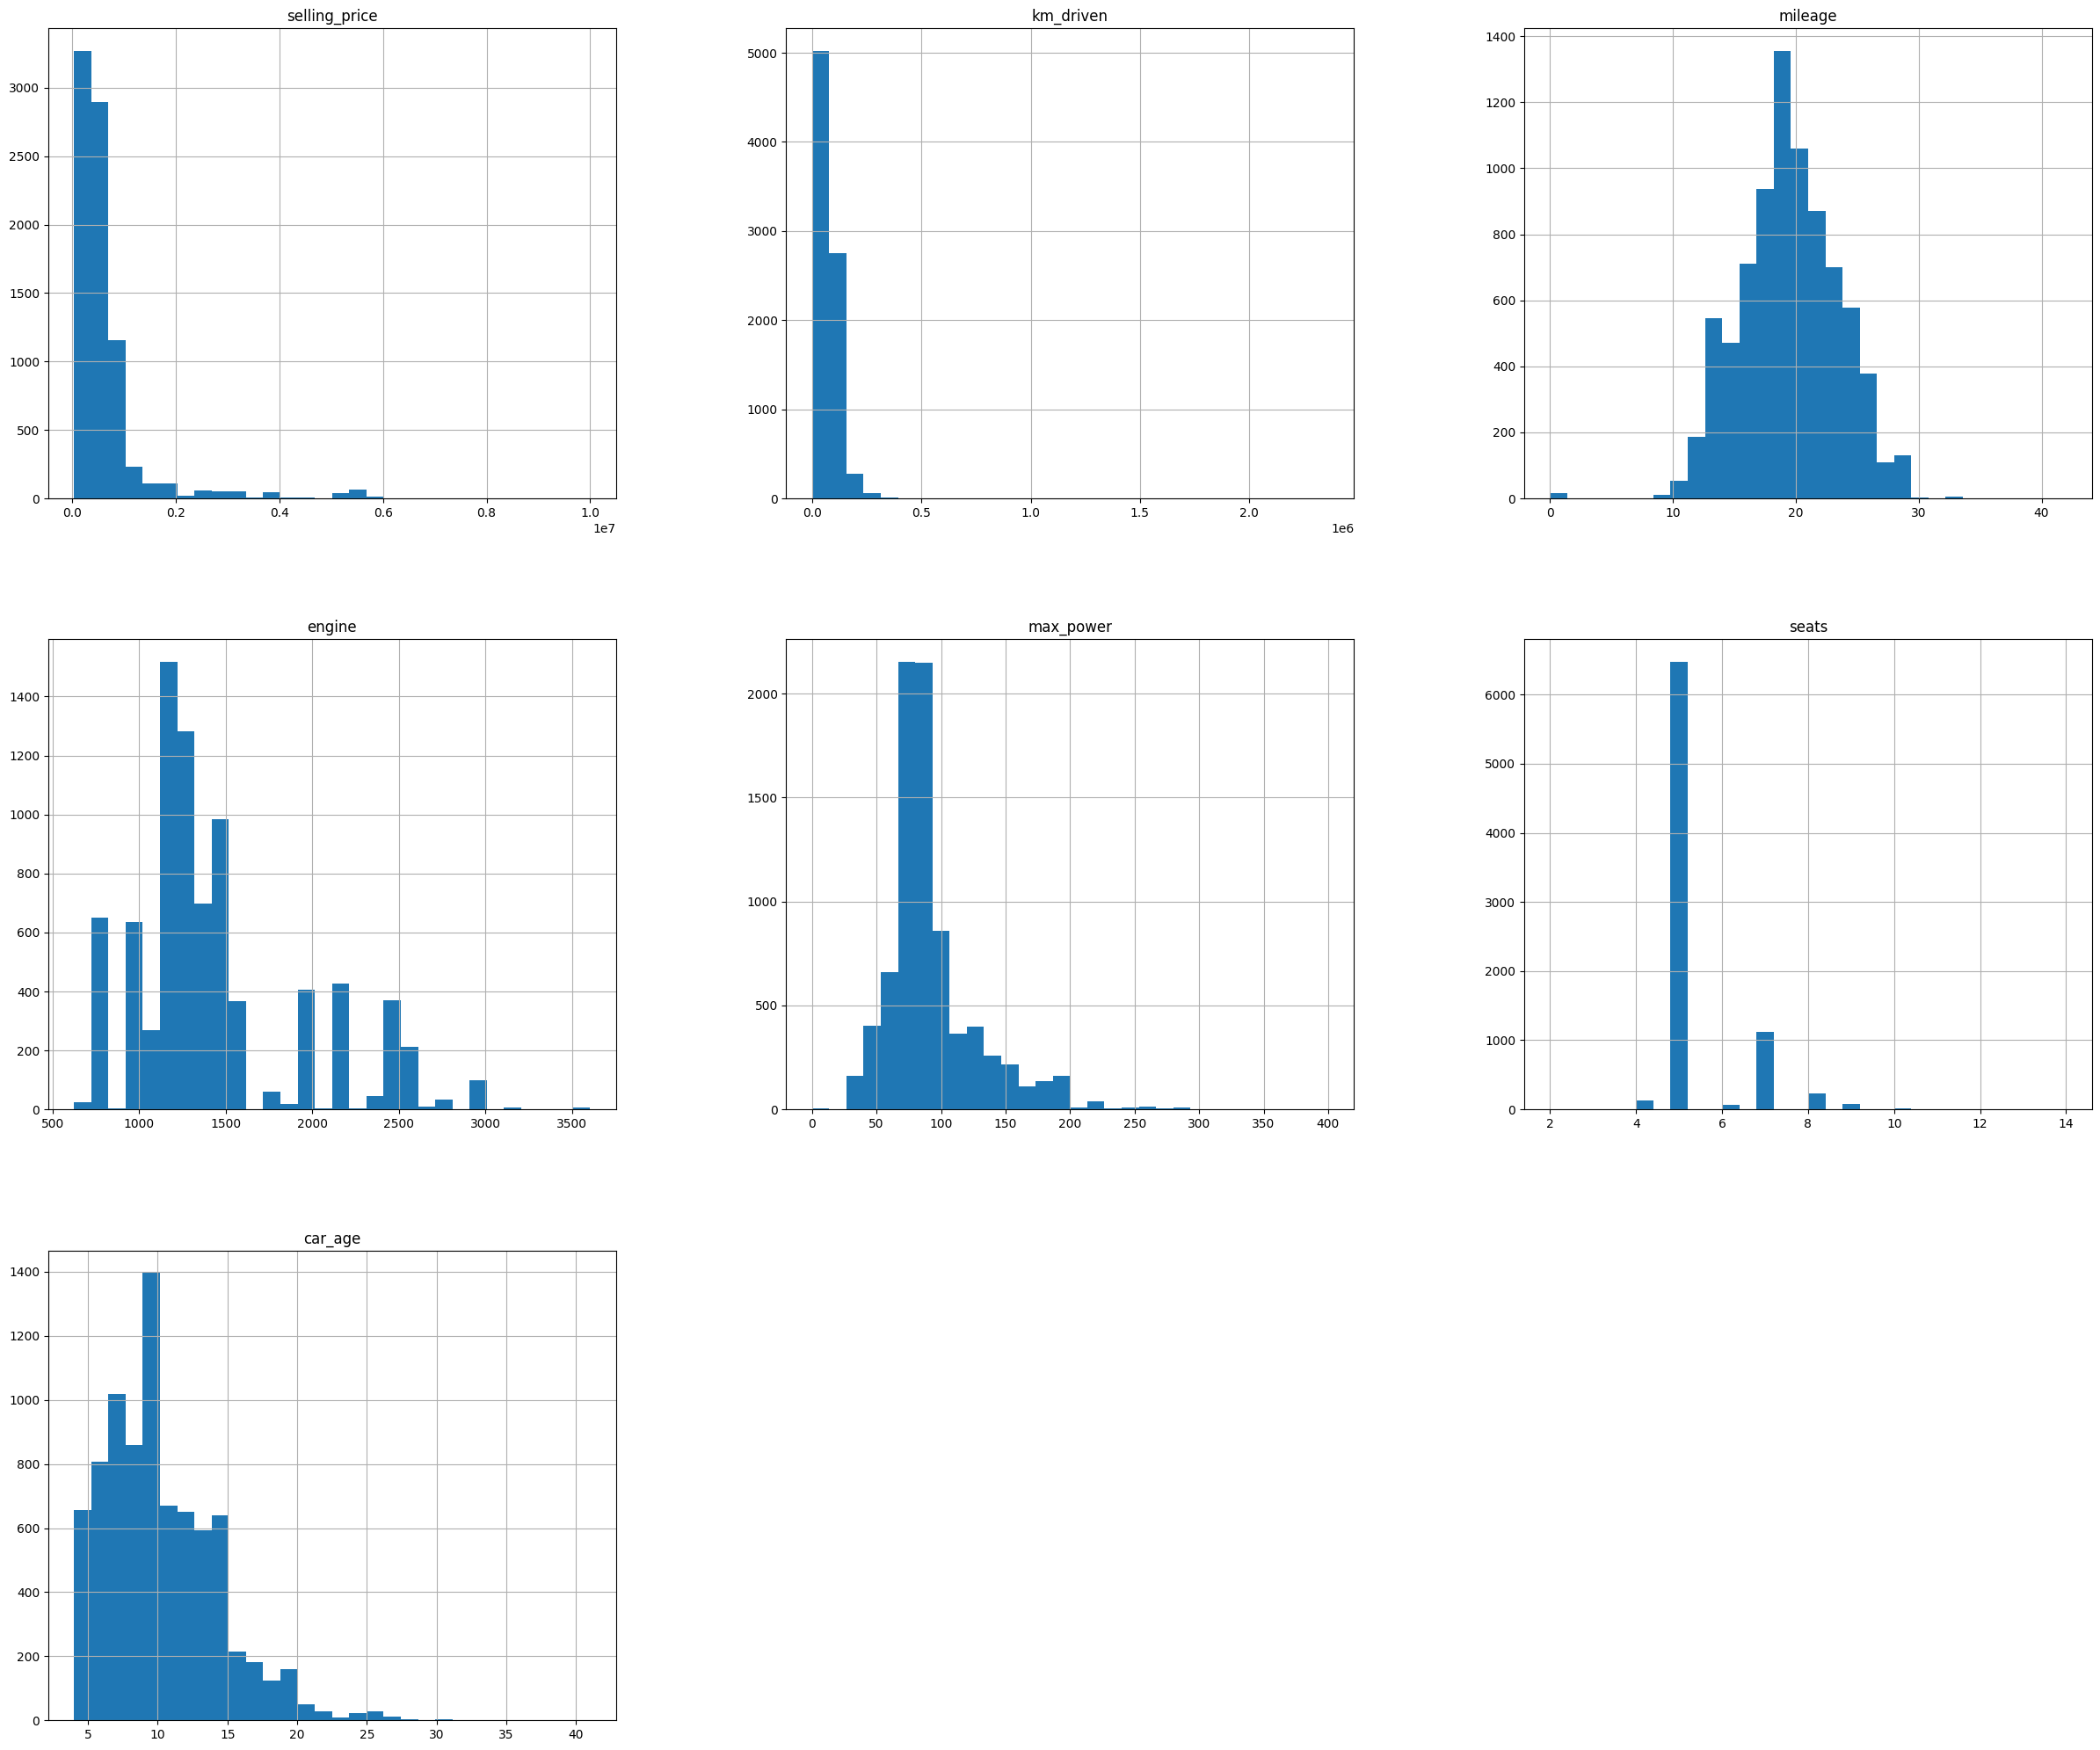

In [49]:
df.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

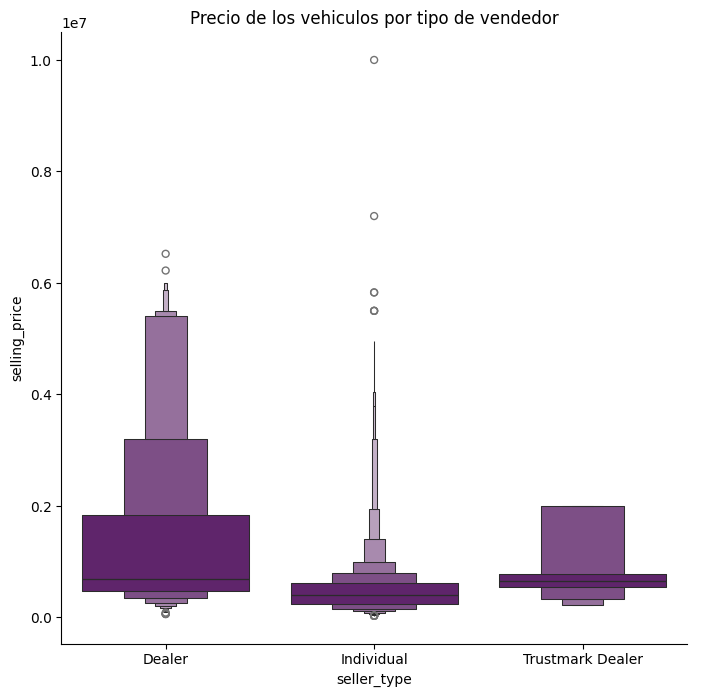

In [65]:
sns.catplot(x = "seller_type",
            y = "selling_price",
            kind = "boxen",
            height = 7,
            aspect = 1,
            color = "#671A76",
            data = df).set(title = "Precio de los vehiculos por tipo de vendedor");

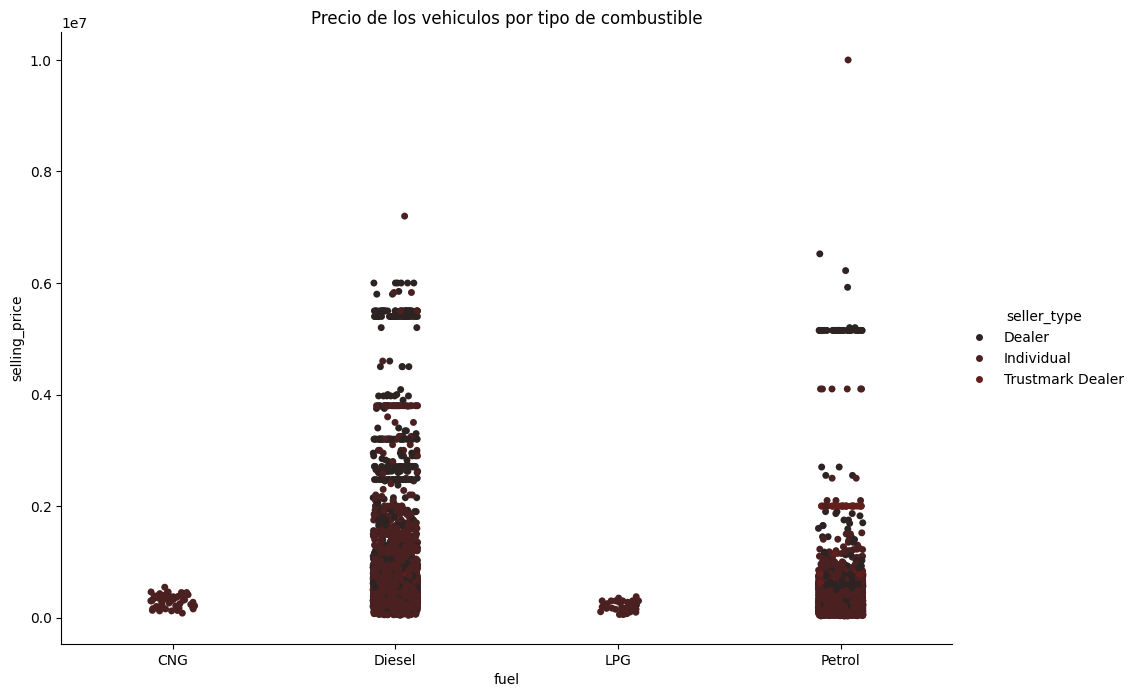

In [66]:
sns.catplot(x = "fuel",
            y = "selling_price",
            kind = "strip",
            hue = "seller_type",
            height = 7,
            aspect = 1.4,
            color = "#661E1D",
            data = df).set(title = "Precio de los vehiculos por tipo de combustible");

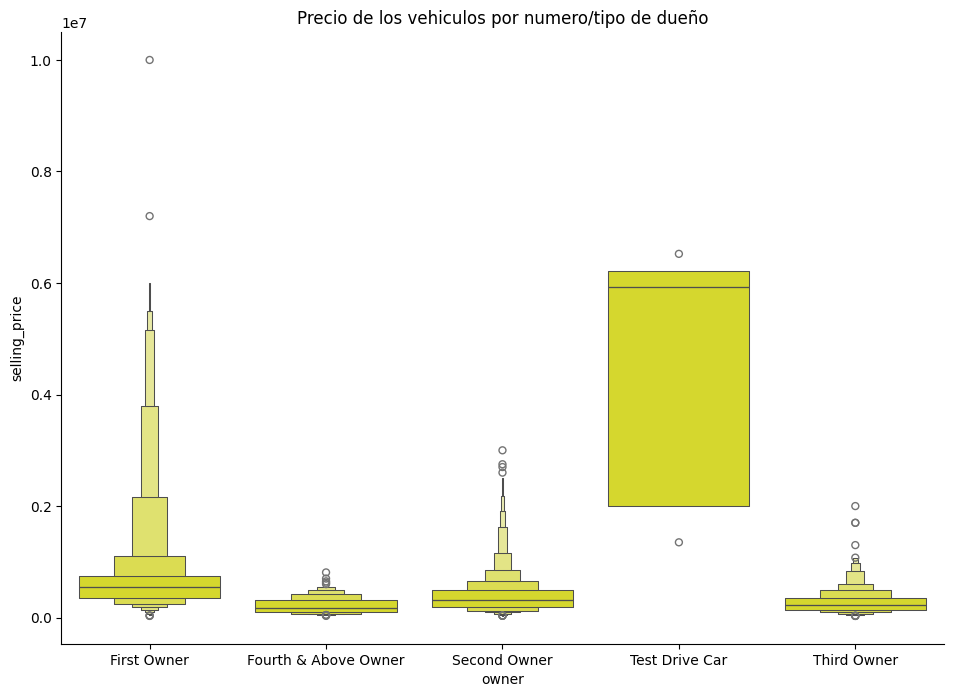

In [67]:
sns.catplot(x = "owner",
            y = "selling_price",
            kind = "boxen",
            height = 7,
            aspect = 1.37,
            color = "#F0F312",
            data = df).set(title = "Precio de los vehiculos por numero/tipo de dueño");

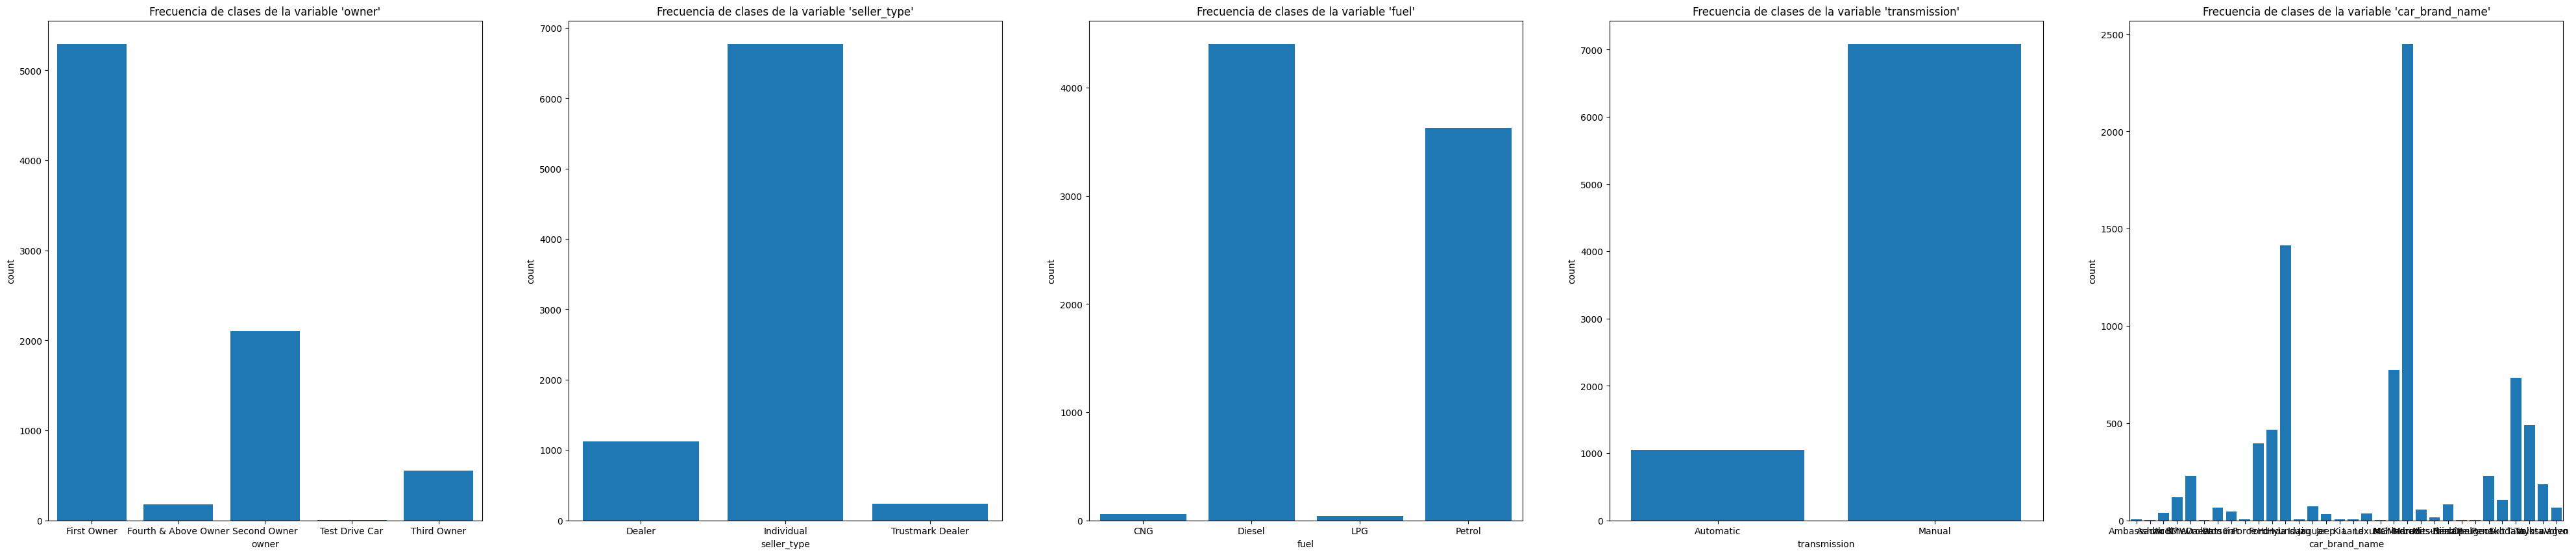

In [68]:
fig, axes = plt.subplots(1, 5, figsize = (50, 10))

sns.barplot(ax = axes[0], x = df["owner"].value_counts().index, y = df["owner"].value_counts(),
            saturation = 1).set(title = "Frecuencia de clases de la variable 'owner'");

sns.barplot(ax = axes[1], x = df["seller_type"].value_counts().index, y = df["seller_type"].value_counts(),
            saturation = 1).set(title = "Frecuencia de clases de la variable 'seller_type'");

sns.barplot(ax = axes[2], x = df["fuel"].value_counts().index, y = df["fuel"].value_counts(),
            saturation = 1).set(title = "Frecuencia de clases de la variable 'fuel'");

sns.barplot(ax = axes[3], x = df["transmission"].value_counts().index, y = df["transmission"].value_counts(),
            saturation = 1).set(title = "Frecuencia de clases de la variable 'transmission'");

sns.barplot(ax = axes[4], x = df["car_brand_name"].value_counts().index, y = df["car_brand_name"].value_counts(),
            saturation = 1).set(title = "Frecuencia de clases de la variable 'car_brand_name'");  


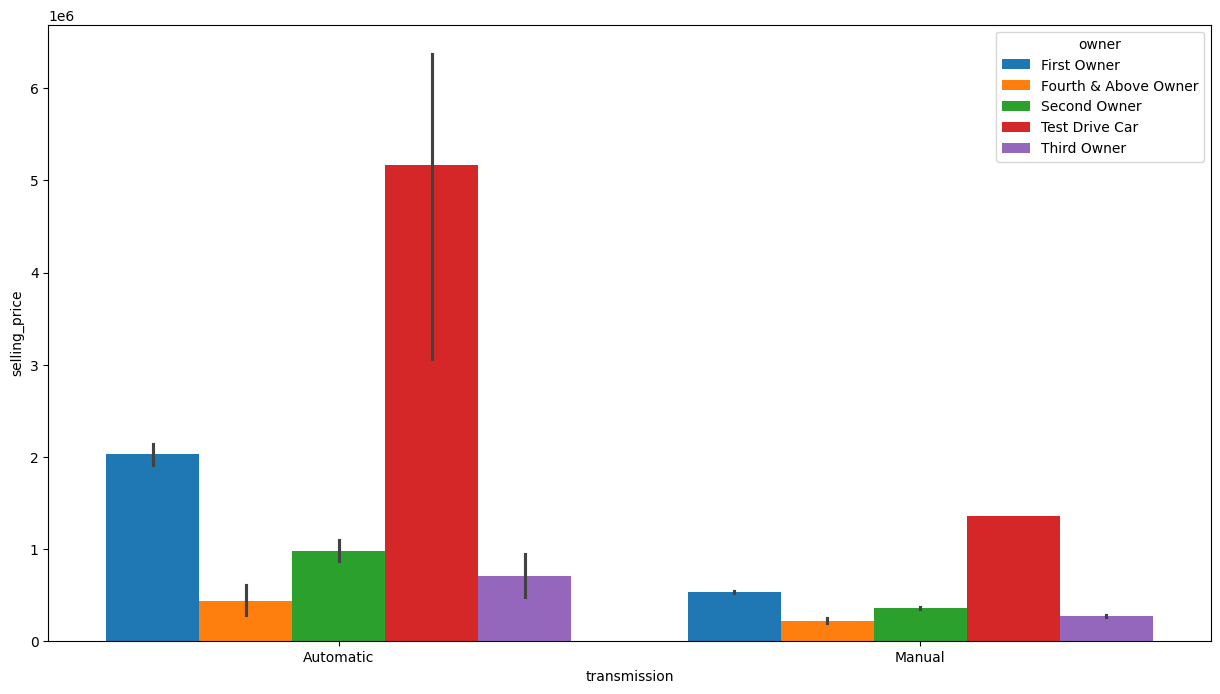

In [60]:
plt.figure(figsize = (15, 8))
sns.barplot(x = "transmission", y = "selling_price", hue = "owner", data = df, saturation = 1);

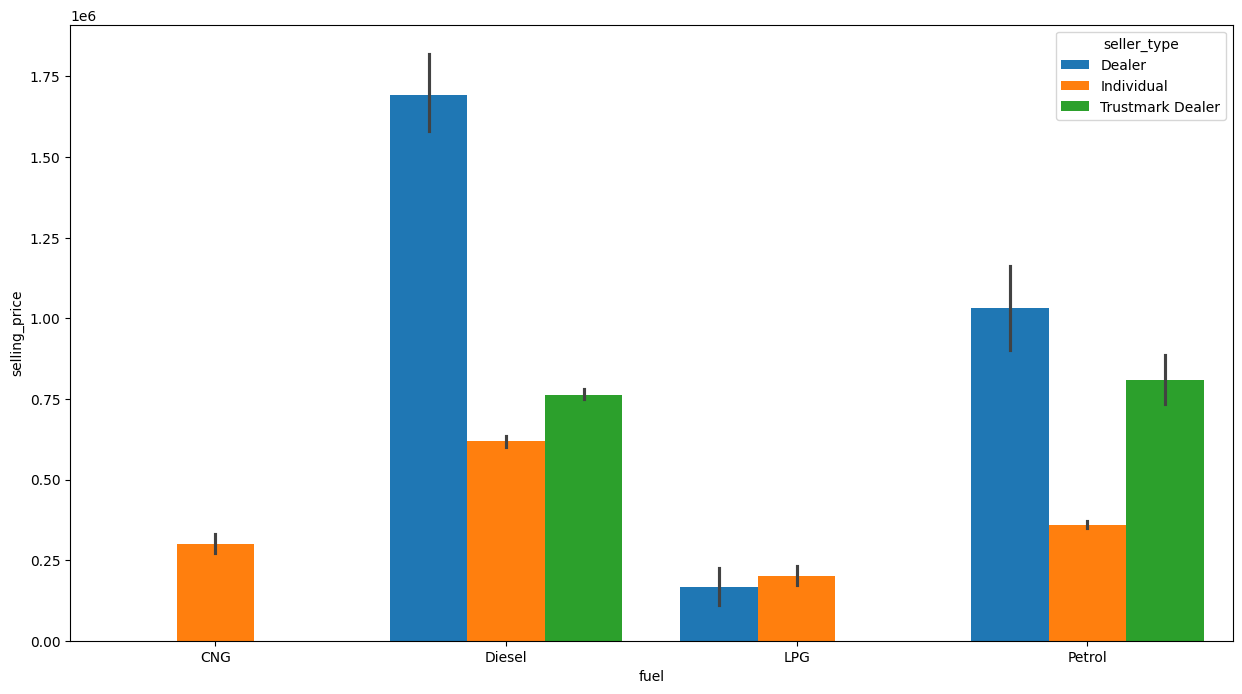

In [61]:
plt.figure(figsize = (15, 8))
sns.barplot(x = "fuel", y = "selling_price", hue = "seller_type", data = df, saturation = 1);

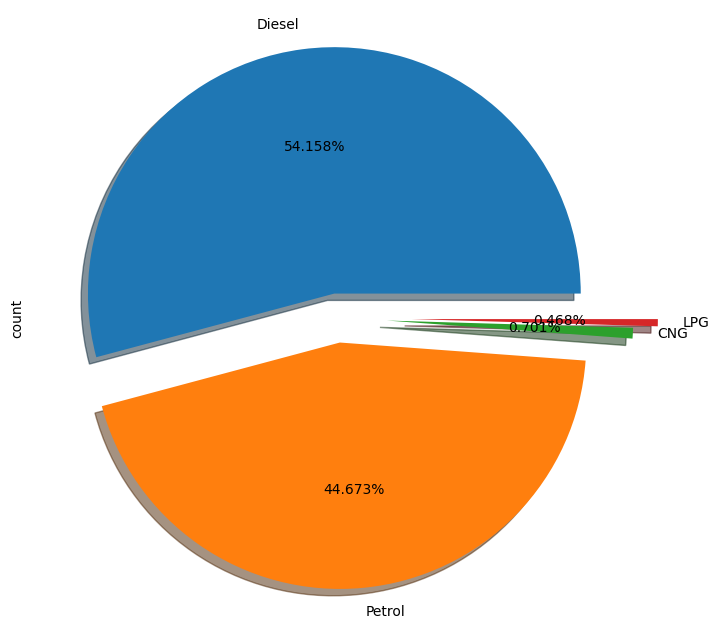

In [62]:
plt.figure(figsize = [8, 8], clear = True, facecolor = "#FFFFFF")
df["fuel"].value_counts().plot.pie(explode = [0.1, 0.1, 0.2, 0.3], autopct='%1.3f%%', shadow = True);

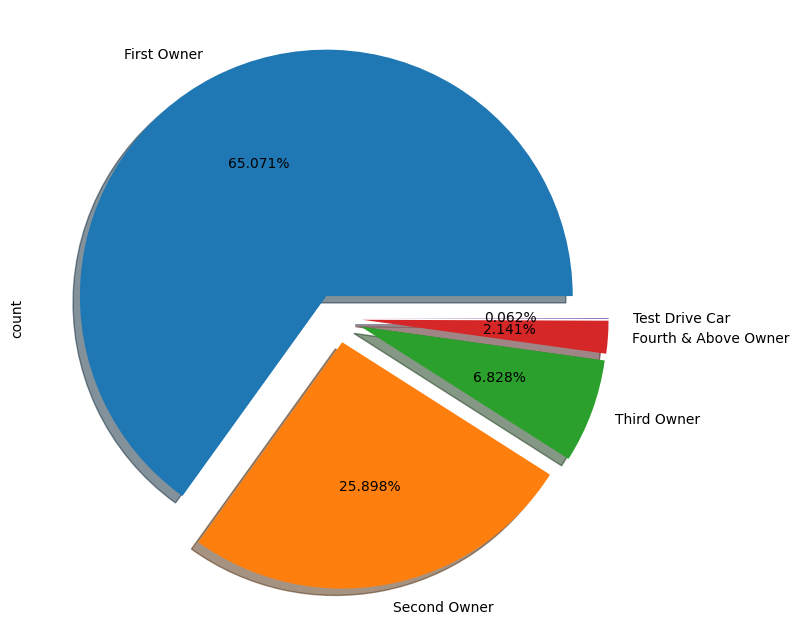

In [63]:
plt.figure(figsize = [8, 8], clear = True, facecolor = "#FFFFFF")
df["owner"].value_counts().plot.pie(explode = [0.1, 0.1, 0.1, 0.1, 0.1], autopct='%1.3f%%', shadow = True);

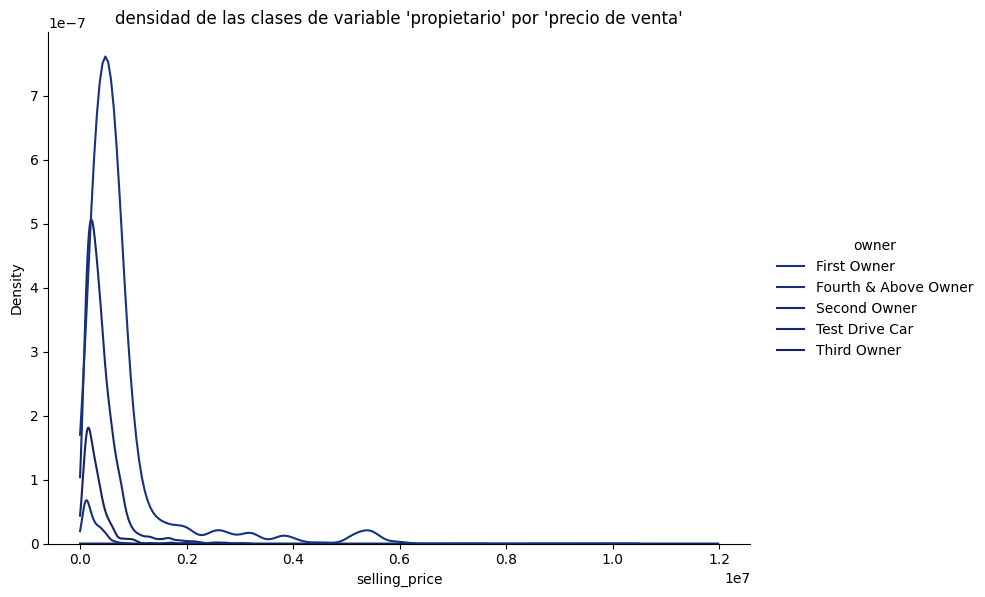

In [69]:
sns.displot(data = df, x = "selling_price", hue = "owner", kind = "kde", height = 6,
            aspect = 1.3, clip=(0, None), palette="ch:rot=-.25, hue = 2, light=.20"
).set(title = "densidad de las clases de variable 'propietario' por 'precio de venta'");

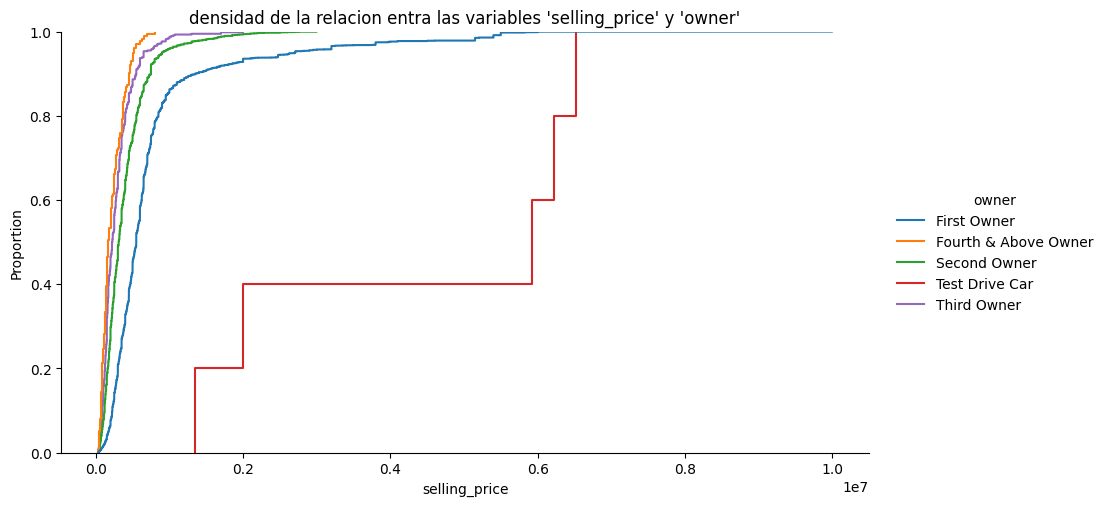

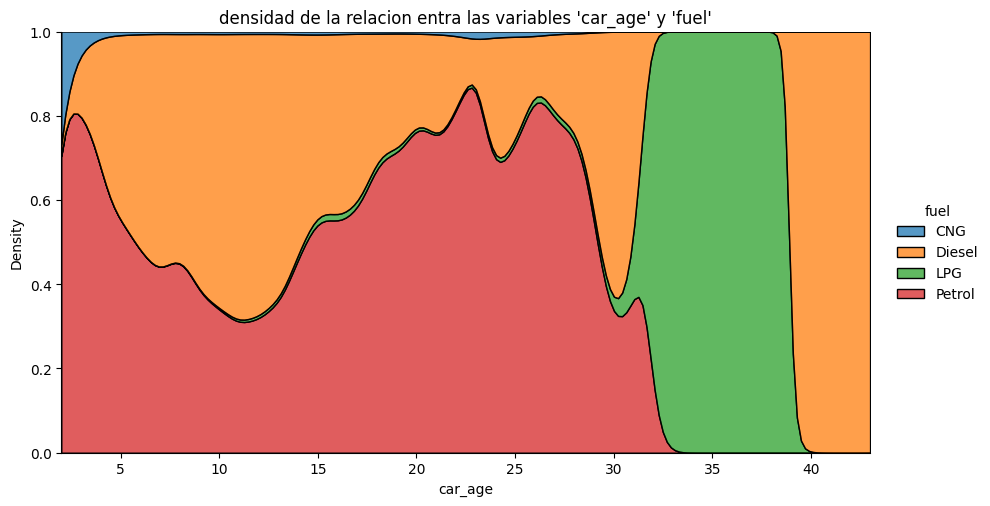

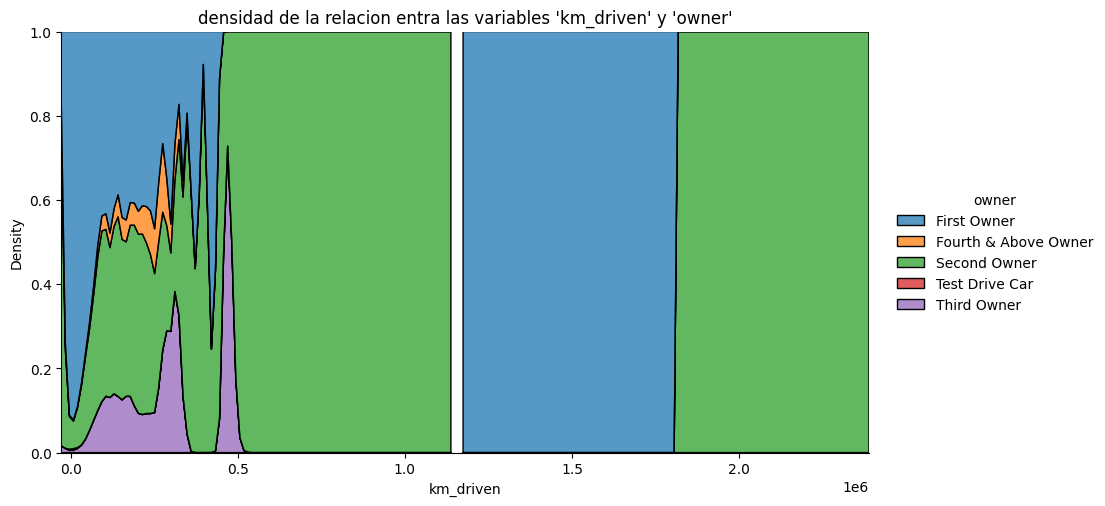

In [71]:
sns.displot(
    data = df, x = "selling_price", hue = "owner",
    kind = "ecdf", height = 5, aspect = 1.8).set(title =  "densidad de la relacion entra las variables 'selling_price' y 'owner'");

sns.displot(
    data = df, x = "car_age", hue = "fuel",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "densidad de la relacion entra las variables 'car_age' y 'fuel'");

sns.displot(
    data = df, x = "km_driven", hue = "owner",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "densidad de la relacion entra las variables 'km_driven' y 'owner'");

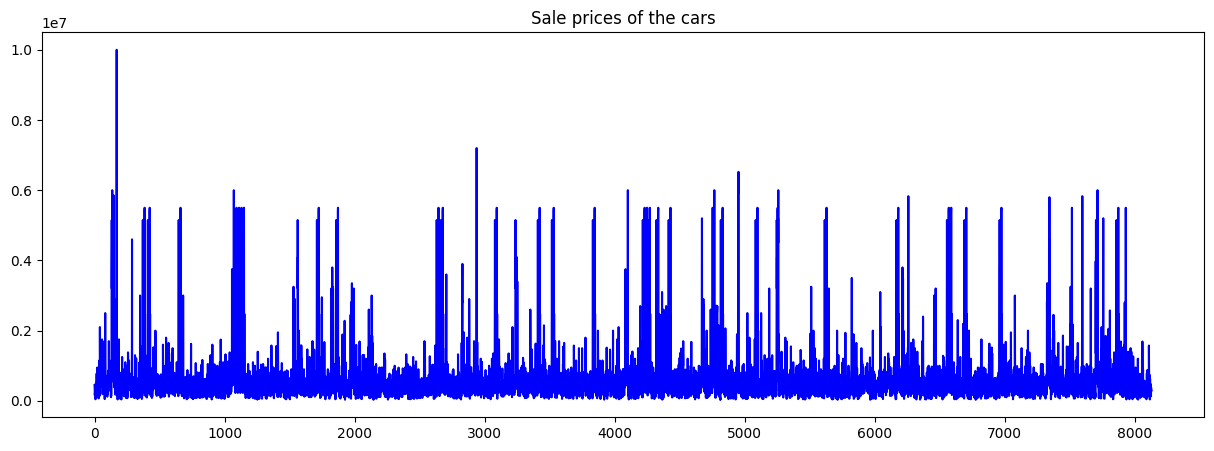

In [75]:
fig, ax = plt.subplots(figsize = (15, 5))
sale_price = list()
for sp in df["selling_price"].values:
    sale_price.append(sp)
sale_price = pd.Series(sale_price)
sale_price.plot(kind = "line", colormap = "winter").set_title("Sale prices of the cars");

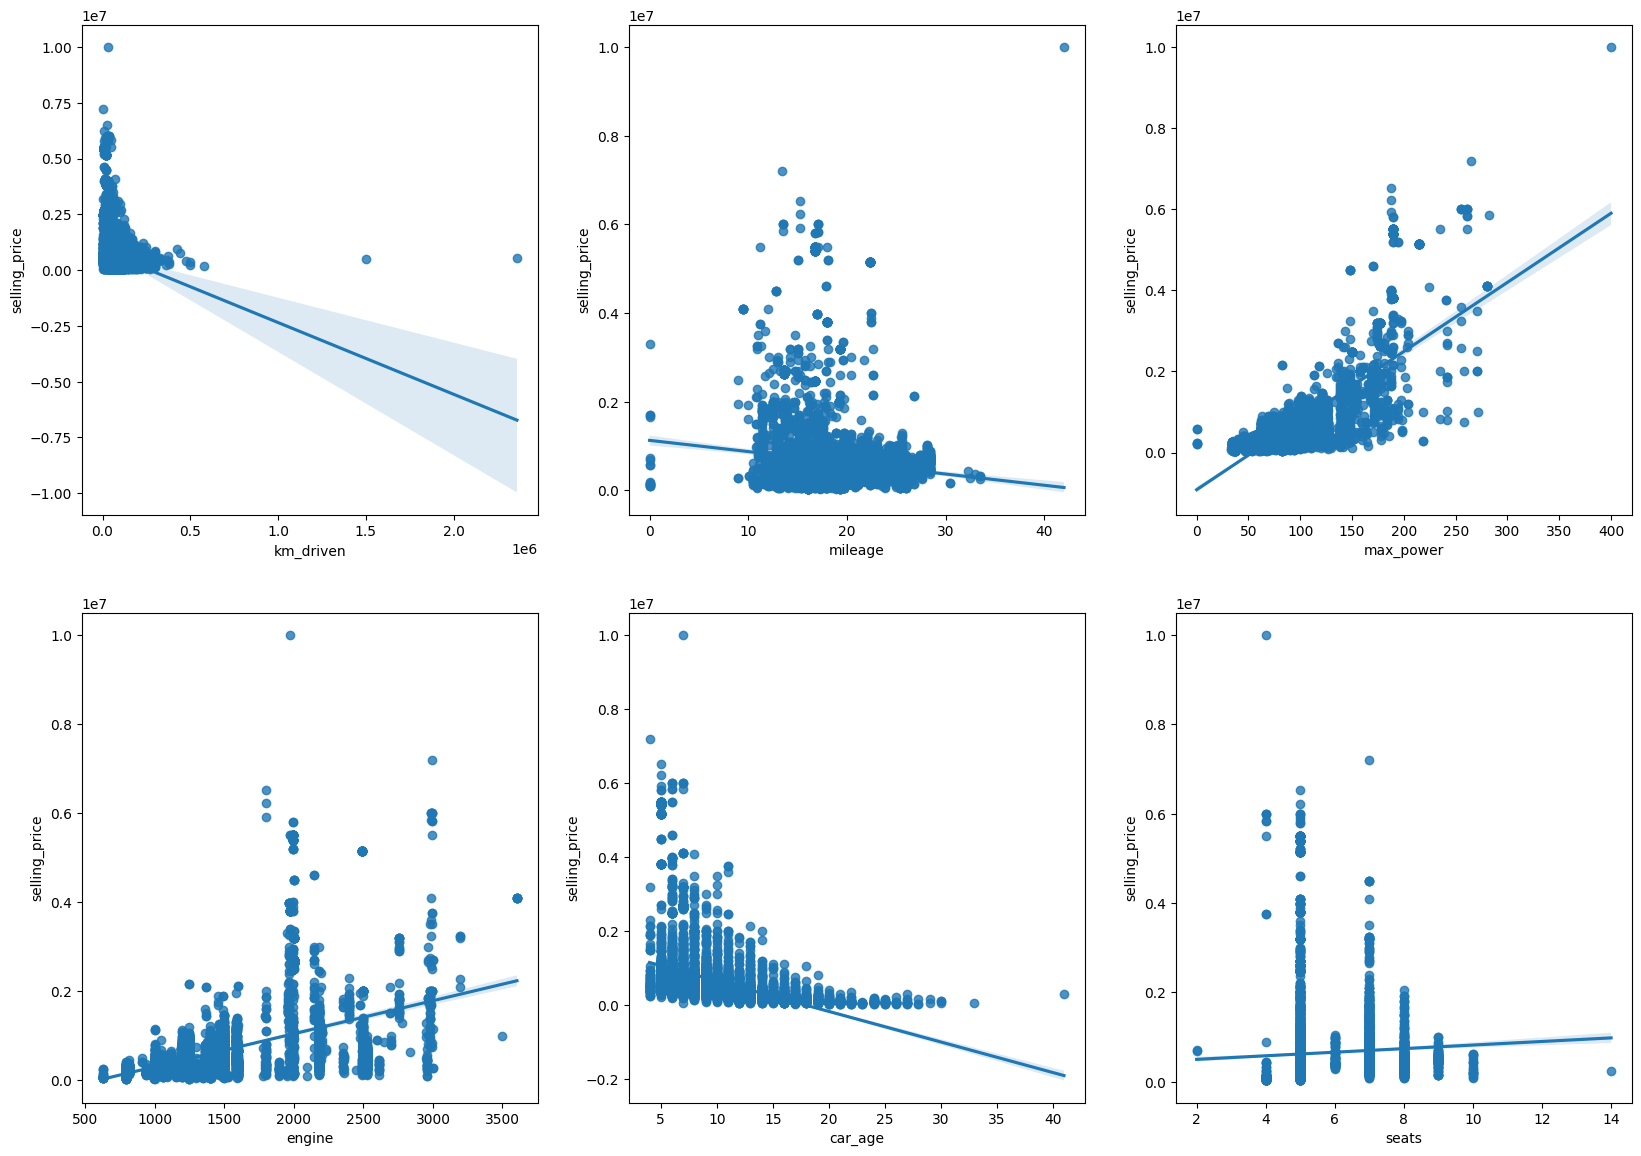

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

sns.regplot(ax = axes[0], x = "km_driven", y = "selling_price", data = df);
sns.regplot(ax = axes[1], x = "mileage", y = "selling_price", data = df);
sns.regplot(ax = axes[2], x = "max_power", y = "selling_price", data = df);
sns.regplot(ax = axes[3], x = "engine", y = "selling_price", data = df);
sns.regplot(ax = axes[4], x = "car_age", y = "selling_price", data = df);
sns.regplot(ax = axes[5], x = "seats", y = "selling_price", data = df);

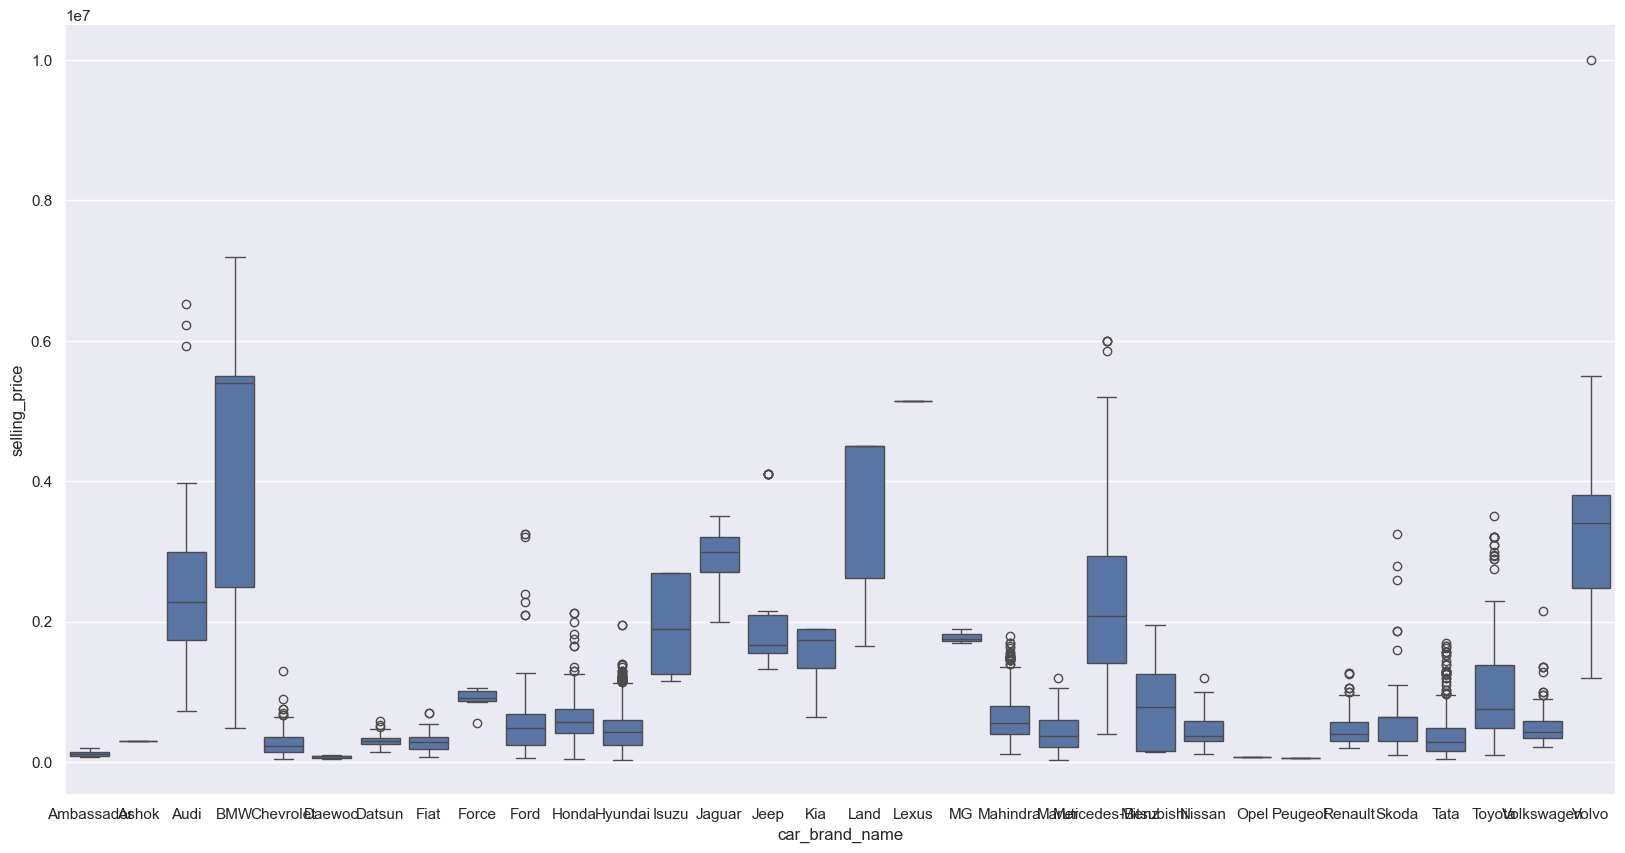

In [ ]:
df['selling_price'] = pd.to_numeric(df['selling_price'], errors='coerce')

sns.set(rc={'figure.figsize':(20, 10)})  # Ajusta el tamaño del gráfico

sns.boxplot(x='car_brand_name', y='selling_price', data=df)
sns.despine()  
sns.set(font_scale=0.5)  

In [81]:
numeric_columns = df.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()

print(correlation_matrix)

               selling_price  km_driven   mileage    engine  max_power  \
selling_price       1.000000  -0.225534 -0.125040  0.458345   0.747935   
km_driven          -0.225534   1.000000 -0.171746  0.198911  -0.040599   
mileage            -0.125040  -0.171746  1.000000 -0.574128  -0.372897   
engine              0.458345   0.198911 -0.574128  1.000000   0.703612   
max_power           0.747935  -0.040599 -0.372897  0.703612   1.000000   
seats               0.047135   0.219860 -0.450578  0.612220   0.194556   
car_age            -0.414092   0.418006 -0.311657 -0.035851  -0.224704   

                  seats   car_age  
selling_price  0.047135 -0.414092  
km_driven      0.219860  0.418006  
mileage       -0.450578 -0.311657  
engine         0.612220 -0.035851  
max_power      0.194556 -0.224704  
seats          1.000000 -0.010222  
car_age       -0.010222  1.000000  


PRUEBAS ESTADISTICAS ANOVA .....

In [84]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
model = ols('selling_price ~ C(fuel)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Results for selling_price by fuel:")
print(anova_table)
if anova_table['PR(>F)'][0] < 0.05:
    print("There is a significant difference in selling_price between fuel types.")
else:
    print("There is no significant difference in selling_price between fuel types.")

ANOVA Results for selling_price by fuel:
                sum_sq      df           F        PR(>F)
C(fuel)   2.293165e+14     3.0  122.880629  7.768068e-78
Residual  5.053596e+15  8124.0         NaN           NaN
There is a significant difference in selling_price between fuel types.


In [85]:
group1 = df[df['owner'] == 'First Owner']['selling_price']
group2 = df[df['owner'] == 'Second Owner']['selling_price']

t_stat, p_value = stats.ttest_ind(group1, group2, nan_policy='omit')
print("\nT-Test Results for selling_price between First Owner and Second Owner:")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference in selling_price between First Owner and Second Owner.")
else:
    print("There is no significant difference in selling_price between First Owner and Second Owner.")



T-Test Results for selling_price between First Owner and Second Owner:
T-statistic: 18.752236657760108, P-value: 1.0947678907961571e-76
There is a significant difference in selling_price between First Owner and Second Owner.


In [86]:
auto = df[df['transmission'] == 'Manual']['selling_price']
manual = df[df['transmission'] == 'Automatic']['selling_price']

h_stat, p_value = stats.kruskal(auto, manual)
print("\nKruskal-Wallis Test Results for selling_price by transmission type:")
print(f"H-statistic: {h_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference in selling_price between transmission types.")
else:
    print("There is no significant difference in selling_price between transmission types.")


Kruskal-Wallis Test Results for selling_price by transmission type:
H-statistic: 1413.2347506902122, P-value: 2.79575567178353e-309
There is a significant difference in selling_price between transmission types.


MODELOS LINEALES + CORRELACION

In [87]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [88]:
X = df[['km_driven', 'mileage', 'engine']]  
y = df['selling_price']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, positive=False)

In [92]:
y_pred = model.predict(X_test)

In [93]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

R² Score: 0.3838666956670711


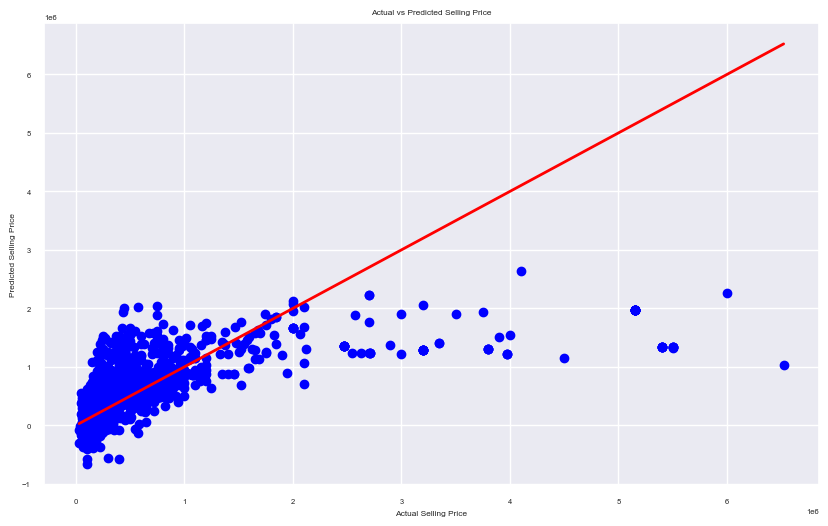

In [94]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Price')
plt.show()


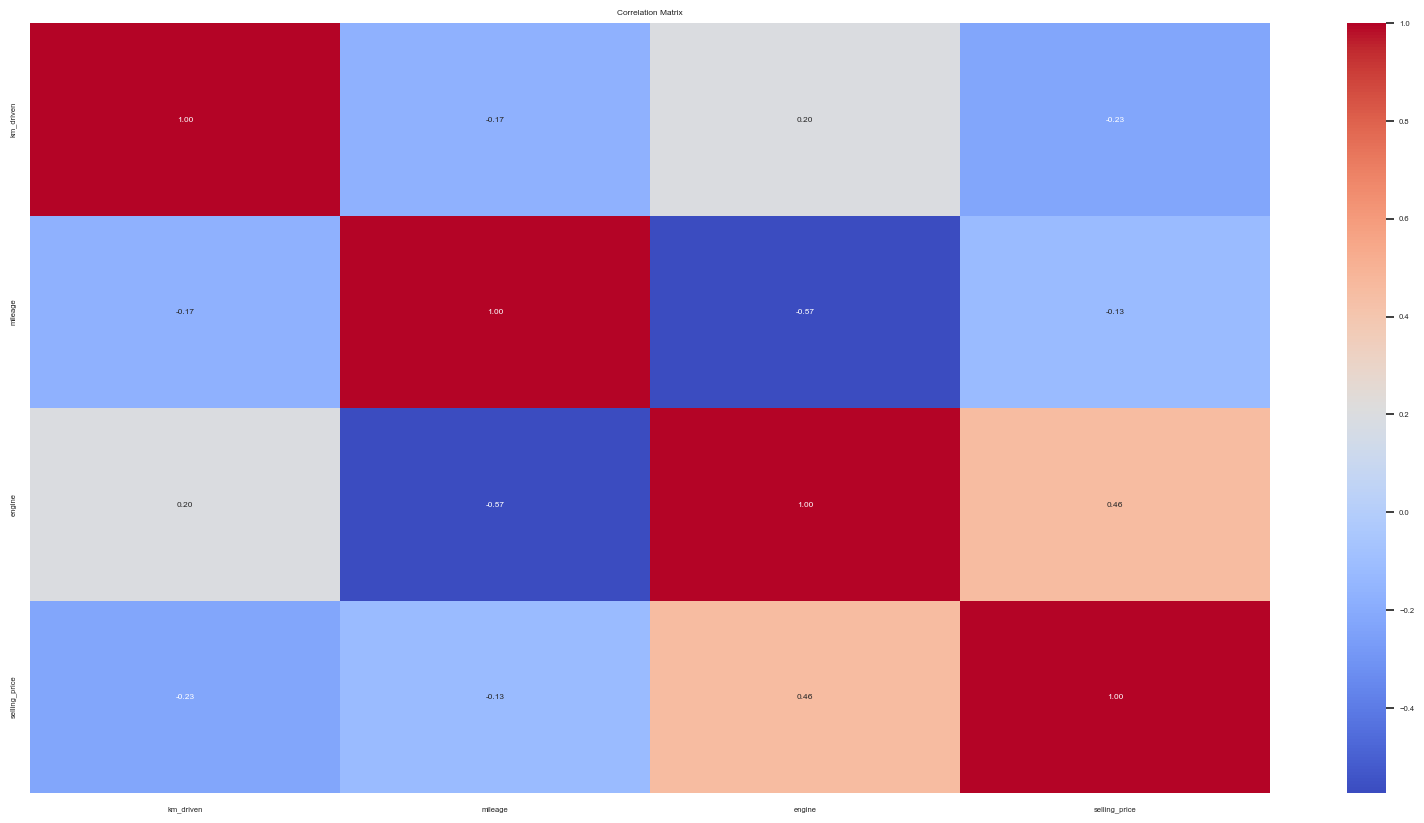

In [95]:
correlation_matrix = df[['km_driven', 'mileage', 'engine', 'selling_price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

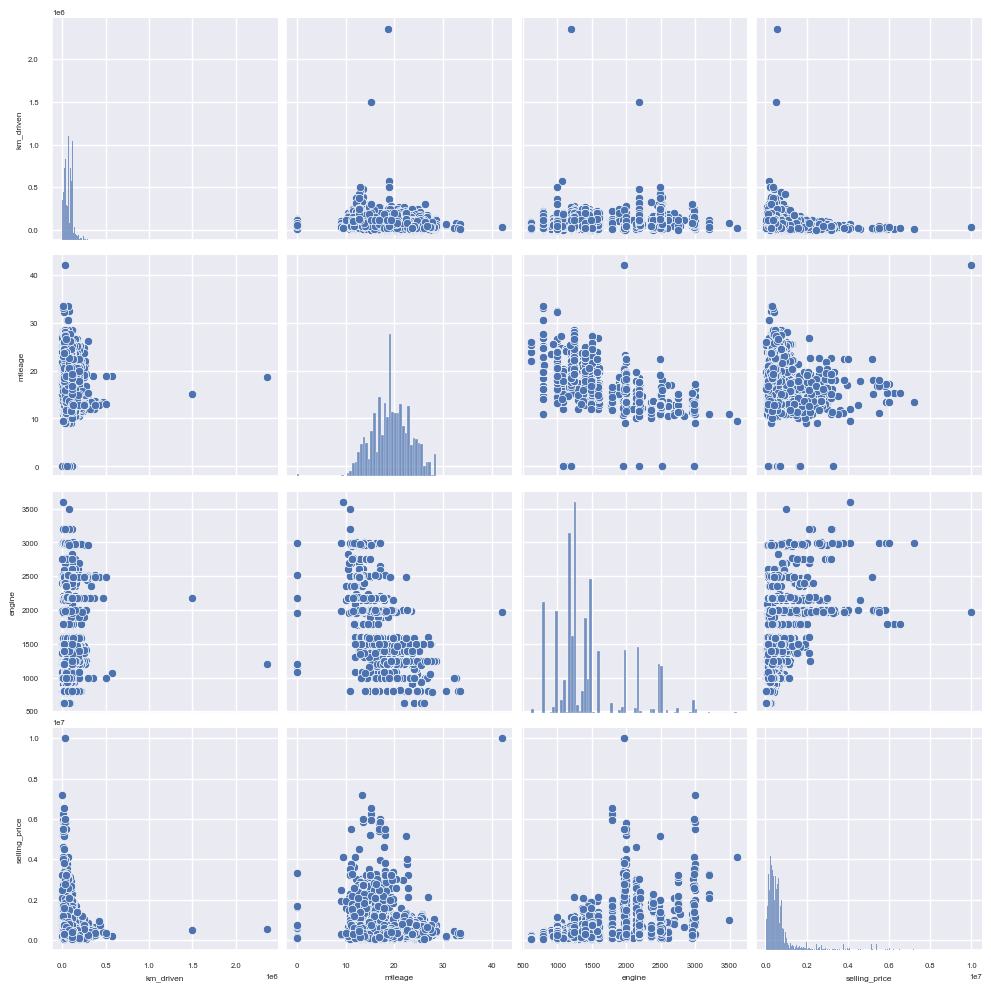

In [96]:
sns.pairplot(df[['km_driven', 'mileage', 'engine', 'selling_price']])
plt.show()


CLASIFICACION DE DATOS

In [97]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [98]:
X = df[['km_driven', 'mileage', 'engine', 'max_power']]  
y = df['fuel']

In [99]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [103]:
y_pred = knn.predict(X_test_scaled)

In [104]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

         CNG       0.86      0.55      0.67        11
      Diesel       0.96      0.97      0.96       857
         LPG       1.00      0.43      0.60         7
      Petrol       0.97      0.96      0.96       751

    accuracy                           0.96      1626
   macro avg       0.94      0.73      0.80      1626
weighted avg       0.96      0.96      0.96      1626



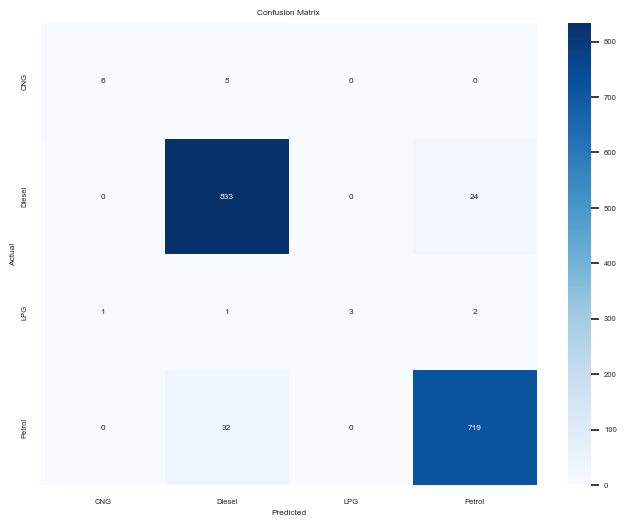

In [105]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [107]:
# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Precisión general (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión general del modelo: {accuracy:.2f}")

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.96      0.97      0.96       857
           2       1.00      0.43      0.60         7
           3       0.97      0.96      0.96       751

    accuracy                           0.96      1626
   macro avg       0.94      0.73      0.80      1626
weighted avg       0.96      0.96      0.96      1626

Precisión general del modelo: 0.96


CLUSTERING DE DATOS
Metodo del codo:
Muestra el número óptimo de clústeres que mejor separa los autos basándose en sus características, como:
Precio de venta (selling_price).
Kilometraje (km_driven).
Eficiencia de combustible (mileage).
Potencia del motor (max_power).
En específico: Si el codo ocurre en, por ejemplo, k=3, significa que los autos se pueden agrupar en tres categorías principales basadas en similitudes de esas características.
Clusteres:
Muestra cómo los autos se agrupan en distintas categorías.
En el dataset:
Cada clúster representa un grupo de autos con características similares:
Cluster 1: Autos económicos con bajo precio, menor potencia y mayor kilometraje.
Cluster 2: Autos medianos con precio moderado y especificaciones equilibradas.
Cluster 3: Autos premium con alto precio, mayor potencia y menor kilometraje.
Los autos de marcas específicas (como Maruti, Hyundai o BMW) podrían estar más presentes en ciertos clústeres dependiendo de su posicionamiento en el mercado.


In [108]:
features = ["selling_price", "km_driven", "mileage", "engine", "max_power", "car_age"]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(scaled_data, columns=features)

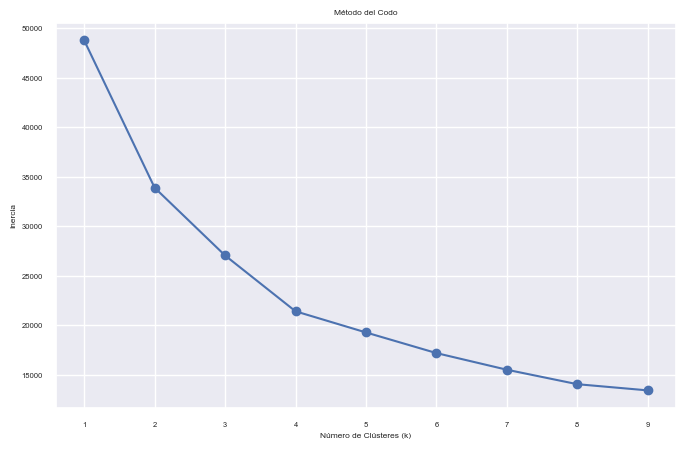

In [116]:
from sklearn.cluster import KMeans
# Método del codo
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficar la inercia
#Objetivo: Determinar el número óptimo de clústeres para el modelo K-Means.
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

In [111]:
# Entrenar modelo con k=3 (suponiendo que es óptimo)
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(df_scaled)


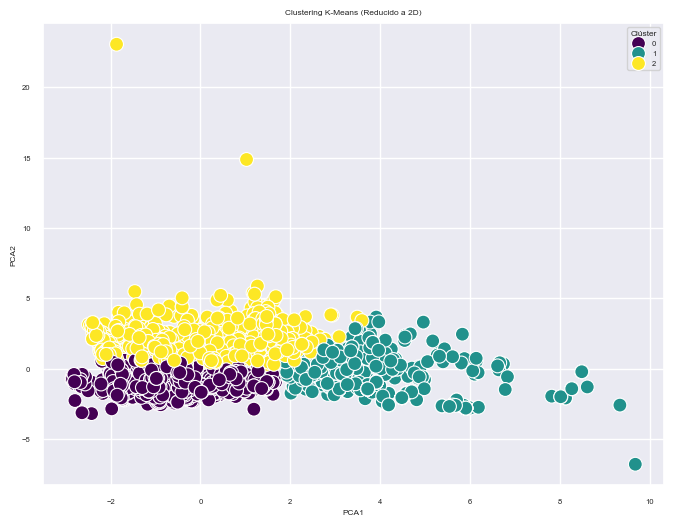

In [112]:
from sklearn.decomposition import PCA

# Reducir dimensiones a 2 componentes principales
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled)

# Crear un DataFrame con las componentes principales y los clústeres
df_reduced = pd.DataFrame(reduced_data, columns=["PCA1", "PCA2"])
df_reduced["cluster"] = df["cluster"]

# Visualización de los clústeres
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_reduced, x="PCA1", y="PCA2", hue="cluster", palette="viridis", s=100)
plt.title("Clustering K-Means (Reducido a 2D)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Clúster")
plt.show()


FORECASTING: SE VA A TRATAR DE PREDECIR EL PRECIO DE VENTA DE LOS AUTOS:)

In [117]:
from sklearn.preprocessing import OneHotEncoder
X = df.drop(columns=['selling_price'])
y = df['selling_price']

categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner', 'car_brand_name']
numerical_columns = X.columns.difference(categorical_columns)


In [119]:

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),  # Pasar las variables numéricas sin cambios
        ('cat', OneHotEncoder(), categorical_columns)  # OneHotEncoder para las columnas categóricas
    ])


In [121]:
from sklearn.pipeline import Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=True, n_jobs=None,
                                   remainder='drop', sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num', 'passthrough',
                                                  Index(['car_age', 'cluster', 'engine', 'km_driven', 'max_power', 'mileage',
       'seats'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dty...ass 'numpy.float64'>,
                                                                feature_name_combiner='concat',
                                                                handle_unknown='error',
                                                                max_categories=None,
                                                                min_frequency=None,
                                                                sparse_output=True),
                                                  ['fuel', 'seller_type',
                                                   'transmission', 'owner',
                                                   'car_brand_name'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  positive=False))],
         verbose=False)

In [123]:
y_pred = model.predict(X_test)

In [124]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 194931947252.68555
R-squared: 0.7026139214954633


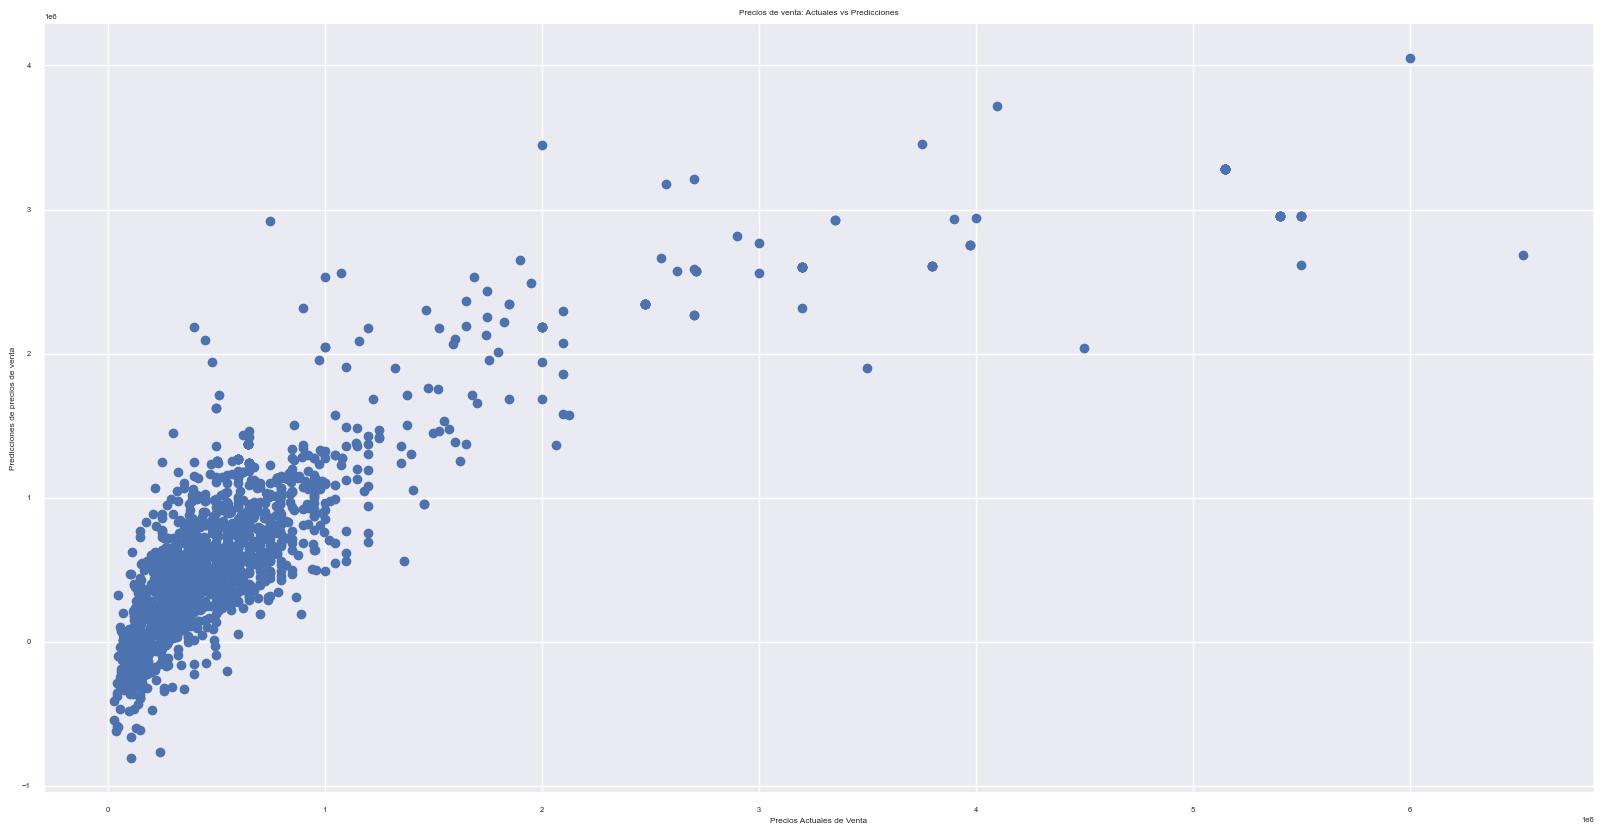

In [127]:
plt.scatter(y_test, y_pred)
plt.xlabel('Precios Actuales de Venta')
plt.ylabel('Predicciones de precios de venta')
plt.title('Precios de venta: Actuales vs Predicciones')
plt.show()

In [131]:

from wordcloud import WordCloud

WORDCLOUD DE MI DATASET

In [132]:
text = " ".join(df["fuel"]) + " " + " ".join(df["seller_type"]) + " " + " ".join(df["transmission"]) + " " + " ".join(df["car_brand_name"])


In [133]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)


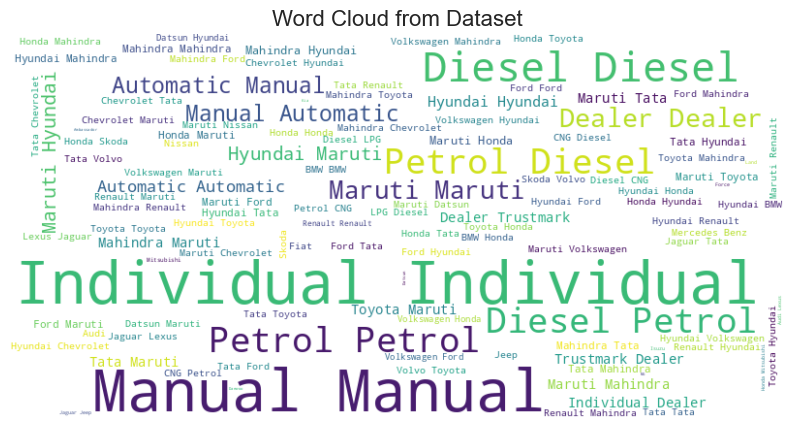

In [134]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from Dataset", fontsize=16)
plt.show()